<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Final Delivery</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201506219 - [up201506219@fe.up.pt](mailto:up201506219@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/>

---

# Code

## Initialization

### Import modules

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling
import matplotlib.pyplot as plt # to display plots
from sklearn.model_selection import KFold, StratifiedKFold # for cross-validation, needs scipy
np.seterr(divide='ignore', invalid='ignore'); # avoid unnecessary messages

### Initialize constants

In [2]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
N_FEATURES   = 22 # the number of features in the dataset
LABEL_INDEX  = 24 # the index in the dataset where the label to predict is
BATCH_SIZE   = 100 # batch size for the train, evaluation and prediction
NUM_CLASSES  = 10 # last layer, num classifications
NUM_ITEMS    = 7195 #Num items in dataset
CROSS_VALIDATION_FUNCTION = StratifiedKFold # use KFold to ignore class representation
ACTIVATION_FUNCTION = tf.nn.relu # default is tf.nn.relu, cpuld be sigmoid

## Helper Functions

In this section we include functions that are directed at helping the visualisation of the project, the manipulation of data and the creation, training and evaluation of models. Here functions that start with an underscore (_) are purely 'private' helper functions and shouldn't be used or even considered for the evaluation of the report

### Chart Drawing and Visualization functions

In [3]:
from IPython.core.display import display_html, HTML
# function to print string into visual HTML
def html(s, html_tag=None):
    if html_tag:
        s = tag(html_tag, s)
    display_html(HTML(s))
def tag(tag, s):
    return "<%s>%s</%s>" % (tag, s, tag)

In [4]:
from IPython.display import display
# receives paddings and a list @layer_sizes with the number of nodes to draw
def _draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
# helper function to draw a neural network
def drawNN(hidden_layers, figsize=(12, 12), name=None):
    #plt.ioff() #plt.ion()
    plt.tight_layout()
    fig = plt.figure(figsize=figsize);
    ax = fig.gca()
    ax.axis('off')
    _draw_neural_net(ax, .1, .9, .1, .9, [N_FEATURES] + hidden_layers + [NUM_CLASSES])
    display(fig);
    plt.close();

In [5]:
# create an abstract histogram
def _draw_label_distribution(label_column, title_text):
    label_count = pd.Series.value_counts(label_column, normalize=True, sort=False)
    label_count = label_count.sort_index()
    label_count.plot(kind='barh', title=title_text, stacked=True, fontsize=15, figsize=(8,8), color="darkblue" )

# create a histogram with the distribution of species
def draw_species_distribution_chart(df, title_text="Species Dataset Distribution"):
    species_column = df['Species']
    _draw_label_distribution(species_column, title_text)

### Creating Deep Neural Network Models 
 * `my_feature_columns`        - the features that the model should receive as input
 * `inner_layers_architecture` - a list of N hidden layers where N[i] is the number of nodes of the layer i

In [6]:
def create_DNN(my_feature_columns, inner_layers_architecture, save_folder_path=None, num_classes=NUM_CLASSES):
    # Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
    classifier = tf.estimator.DNNClassifier(
            feature_columns = my_feature_columns,
            hidden_units = inner_layers_architecture, # 1:-1 removes the first and last elements of the architecture
            n_classes = num_classes, # num nodes of final layer
            model_dir = save_folder_path, # value None means it will be saved in temp
            activation_fn = ACTIVATION_FUNCTION, # activation function to use
    )
    
    return classifier

### Training Models

In [7]:
SHUFFLE_PARAM = NUM_ITEMS * 10 #df.shape[0] * 10
# helper function to yield a part of the training data to be used by TF's classifier.train method
def _train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(SHUFFLE_PARAM).repeat().batch(BATCH_SIZE)

In [8]:
# Train a model, given the train data and the number of steps
def train_model(classifier, train_x, numeric_train_y, num_steps=1000):
    classifier.train(input_fn=lambda:_train_input_fn(train_x, numeric_train_y), steps=num_steps)

### Evaluating Models

In [9]:
# helper function for the classifier.evaluate method
def _eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [10]:
# Evaluate a model - returns a tuple (eval_results, global_step)
def evaluate_model(classifier, test_x, numeric_test_y):
    return classifier.evaluate(input_fn=lambda:_eval_input_fn(dict(test_x), numeric_test_y))

In [11]:
# predict from a trained model - returns a list of the predictions
def predict_model(classifier, predict_x):
    predictions = list(classifier.predict(input_fn=lambda:_eval_input_fn(dict(predict_x))))
    return [el["class_ids"][0] for el in predictions]

### Dataset Splitting

In [12]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def _convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return [unique_labels.index(l) for l in labels]

In [13]:
def _format_TF_data(train, test):
    # split dataframes into X (features) and y (classes) - use species as label
    train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    
    # for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
    numeric_train_y = _convert_labels_to_number(train_y.iloc[:,0])
    numeric_test_y  = _convert_labels_to_number(test_y.iloc[:,0])
    
    return (train_x, numeric_train_y, test_x, numeric_test_y)

In [14]:
# Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
def get_TF_feature_columns(df):
    data_df = df.iloc[:,:N_FEATURES]
    return [tf.feature_column.numeric_column(key=key) for key in list(data_df)]

#### Simple data splitting into Train and Test data

In [15]:
# returns a single iteration
def simple_data_split_generator(df, labels, train_fraction):
    train=df.sample(frac=train_fraction, random_state=int(time.time()))
    test=df.drop(train.index)
    yield _format_TF_data(train, test) # in a for loop gives one single loop

#### Cross Validation splitting into Train and Test data

In [16]:
def _split_data_by_indices(train_indices, test_indices):
    train = df.iloc[train_indices]
    test = df.iloc[test_indices]
    return _format_TF_data(train, test)

In [17]:
def _get_k_fold_CV_split_indices(df, labels, num_folds = 3):
    k_fold = CROSS_VALIDATION_FUNCTION(n_splits = num_folds, shuffle=True)
    return k_fold.split(df, labels)

In [18]:
def kFoldCV_tf_data_generator(df, labels, train_fraction):
    num_folds = int(1.0 / (1.0 - train_fraction))
    for train_indices, test_indices in _get_k_fold_CV_split_indices(df, labels, num_folds):
        yield(_split_data_by_indices(train_indices, test_indices))

### Hyper-Parameter Tuning
Given a dataset, the respective labels, a function to split the data and another to calculate the number of steps, this function iterates over all the defined architectures in **INNER_LAYERS** and over all the **NUM_STEPS** and over all the  **TRAIN_FRACTIONS** and does the following:
 * Split the data accordingly
 * Train the model
 * Evaluate the model
 * Report the results
 
This can be used for quick comparison of multiple combinations of architectures, number of steps and train fractions, essentially tuning **hyper-parameters**. More can hyper-parameters can be added if needed.

In [19]:
def run_model_iterations(df, labels, data_generator):
    evaluations = []
    for inner_architecture in INNER_LAYERS:
        #drawNN([N_FEATURES] + inner_architecture + [NUM_CLASSES])
        for num_steps in NUM_STEPS:
            for train_fraction in TRAIN_FRACTIONS:
                my_feature_columns = get_TF_feature_columns(df) # seems to need to generate one for each estimator
                classifier = create_DNN(my_feature_columns, inner_architecture)
                (train_x, numeric_train_y, test_x, numeric_test_y) = next(data_generator(df, labels, train_fraction))
                train_model(classifier, train_x, numeric_train_y, num_steps)
                eval_result = evaluate_model(classifier, test_x, numeric_test_y)
                predictions = predict_model(classifier, test_x)
                # evaluation results, only the results of the last evaluation and prediction done on estimator
                evaluations.append({"config": (inner_architecture, train_fraction, num_steps), "eval_result" : eval_result, "prediction": (np.array(predictions), np.array(numeric_test_y))})
    html("Model iterations complete", "h1")
    return evaluations # evaluations can have duplicate 'keys' if k-fold is used

## Evaluation Metrics Used

From the confusion matrix, we derive the number of **true positives** (`TP`), **false positives** (`FP`), **true negatives** (`TN`) and **false negatives** (`FN`).

<img src="report_material/images/multiclass_confusion.png" width="300px" />
<p style="text-align:center">Image of a confusion matrix for a multiclass classification problem</p>

$ precision = \frac{ TP}{TP + FP} $

$ recall  = \frac{TP}{TP + FN} $

$ accuracy = \frac{TP + TN}{TP + FP + FN + TN} $

$ F1-score = 2 \cdot \frac{precision\cdot recall}{precision+ recall} $

Further metrics such as **specificity**, **negative predictive value**, **false positive rate**, **false negative rate** and **false discovery rate** were also calculated, but were not considered when making model decisions

In [20]:
# calculate metrics based on confusion matrix -> precision, recall, f1, ...
def print_metrics(prediction, confusion_matrix):
    predicted, actual = prediction
    
    # get values from confusion matrix for each class
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # false positives
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix) # false negatives
    TP = np.diag(confusion_matrix)  # true positives
    TN = confusion_matrix.sum() - (FP + FN + TP) # true negatives

    # calculate metrics
    TPR = TP/(TP+FN) # Recall, sensitivity, hit rate, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1  =  2 * ((PPV * TPR) / (PPV + TPR)) # f1-score
    ACC = (TP+TN)/(TP+FP+FN+TN) # accuracy
    
    #overall values in percentage
    metrics = tuple(map(lambda v: np.nanmean(v) * 100, [ACC, PPV, TPR, F1]))
    
    # create the table with the statistics
    header = tag("tr", "<th>Species</th><th>Accuracy</th> <th>Precision</th> <th>Recall</th> <th>F1-score</th>")
    body = ""
    footer = tag("tr", "<th>Average</th><th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th>" % metrics)
    for i in range(len(TP)):
        body += tag("tr", "<td>%s</td><td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td>" % (i, ACC[i] * 100, PPV[i] * 100, TPR[i] * 100, F1[i] * 100))
        
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;'>%s%s%s</table>" % (header, body, footer)
    html(table)
    return metrics

In [21]:
# print a confusion matrix after a prediction
def get_confusion_matrix(prediction):
    predicted, actual = prediction
    con_mat = tf.confusion_matrix(actual, predicted, num_classes=NUM_CLASSES)
    with tf.Session():
        return tf.Tensor.eval(con_mat,feed_dict=None, session=None)

### Functions to display and describe the output of a model

In [22]:
def print_configs(configs):
    header = tag("tr", "<th>Hidden Layers</th><th>Training Fraction</th> <th>Number of Steps</th>")
    body = tag("tr", "<th>%s</th><th>%.0f%%</th><th>%s</th>" % (configs[0], configs[1] * 100, configs[2]))
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;text-align=center'>%s%s</table>" % (header, body)
    html(table)

In [23]:
def display_model_results(evaluations):
    # show results, statistics
    print('Num Results: %d' % len(evaluations))
    chart_data = [] # data to create charts later
    for i, e in enumerate(evaluations):
        confusion_matrix = get_confusion_matrix(e["prediction"])
        html("<h2 style='text-align:center'>Iteration %d</h2>" % (i+1))
        
        print_configs(e["config"])
        drawNN(e["config"][0], (7,7))
        
        html("Confusion Matrix:", "h4")
        html("<br/>")
        print(confusion_matrix)
        
        metrics = print_metrics(e["prediction"], confusion_matrix)
        
        html("<hr>")
        
        chart_data.append((e["config"], metrics)) # config, [ACC, PPV, TPR, F1]
    display_model_comparison(chart_data)

In [24]:
# compare different architectures, train ratios and number of steps
def display_model_comparison(chart_data):
#     print(chart_data)
#     plt.rcParams.update({'font.size': 16})
    for percentage in TRAIN_FRACTIONS:
        plt.figure(figsize=(20,10));
        for layers in INNER_LAYERS:
            x, y = [], []
            for data in chart_data:
                if data[0][0] == layers and data[0][1] == percentage:
                    x.append(data[0][2])
                    y.append(data[1][0])
            plt.plot(x, y, '-', label="%s layers" % layers)


        for steps in NUM_STEPS:
            y = []
            for data in chart_data:
                if data[0][2] == steps and data[0][1] == percentage:
                    y.append(data[1][0])
            plt.plot([steps] * len(y), y, 'x', label="%4d steps"%steps, markersize=16)

        plt.title('Evolution of Accuracy for a training fraction of %.f%%' % (percentage * 100))
        plt.legend(loc='best')
        plt.show()

# Main

### Loading Data

In [25]:
# from csv to pandas Dataframe
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF

print("Got %d examples from the .csv" % df.shape[0])
df.head()

Got 7195 examples from the .csv


,MFCCs_1,MFCCs_2,MFCCs_3,MFCCs_4,MFCCs_5,MFCCs_6,MFCCs_7,MFCCs_8,MFCCs_9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [26]:
# get a mapping of all the labels in the Dataset into its integer values (required for Stratified Cross Validation)
labels = _convert_labels_to_number(df.iloc[:,LABEL_INDEX:LABEL_INDEX+1].iloc[:,0])

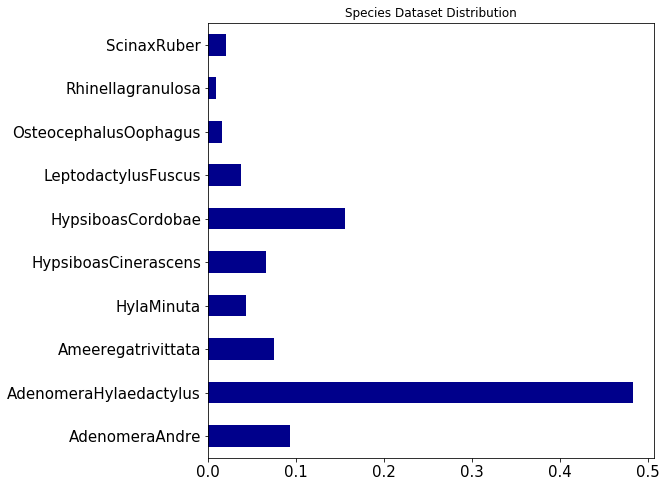

In [27]:
# draw dataset distribution
draw_species_distribution_chart(df)

### Running iterations

In [28]:
### Iterations

# modify here to set model configurations
INNER_LAYERS = [
    [10],
    [100],
    [100, 50, 25],
    [25, 50, 100],
]

TRAIN_FRACTIONS = [
    0.8,
]

NUM_STEPS = [
    1500,   
]

### Initial approach to dataset splitting
Random split into train and test

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [29]:
# this may take a while
evaluations = run_model_iterations(df, labels, simple_data_split_generator)    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Ross\\AppData\\Local\\Temp\\tmpyq4q4h_a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021BFB151278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Ross\AppData\Local\Temp\tmpyq4q4h_a\m

INFO:tensorflow:global_step/sec: 193.601
INFO:tensorflow:loss = 24.192385, step = 100 (0.518 sec)
INFO:tensorflow:global_step/sec: 221.989
INFO:tensorflow:loss = 11.147509, step = 200 (0.451 sec)
INFO:tensorflow:global_step/sec: 216.009
INFO:tensorflow:loss = 14.426526, step = 300 (0.462 sec)
INFO:tensorflow:global_step/sec: 243.95
INFO:tensorflow:loss = 2.4149, step = 400 (0.410 sec)
INFO:tensorflow:global_step/sec: 212.315
INFO:tensorflow:loss = 9.628031, step = 500 (0.471 sec)
INFO:tensorflow:global_step/sec: 202.241
INFO:tensorflow:loss = 2.7845035, step = 600 (0.493 sec)
INFO:tensorflow:global_step/sec: 207.438
INFO:tensorflow:loss = 7.8010707, step = 700 (0.482 sec)
INFO:tensorflow:global_step/sec: 226.76
INFO:tensorflow:loss = 5.8145123, step = 800 (0.441 sec)
INFO:tensorflow:global_step/sec: 210.041
INFO:tensorflow:loss = 3.7138448, step = 900 (0.476 sec)
INFO:tensorflow:global_step/sec: 215.4
INFO:tensorflow:loss = 1.7777642, step = 1000 (0.464 sec)
INFO:tensorflow:global_step

Model iterations complete

Num Results: 4


Iteration 1

Hidden Layers,Training Fraction,Number of Steps
[10],80%,1500


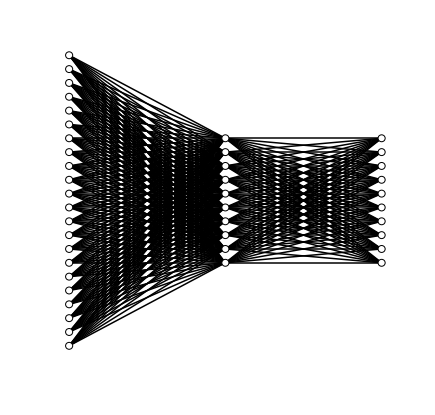

Confusion Matrix:

[[ 40   1   2   2   1   0   0   0   0   0]
 [  1  92   0   0   0   0   0   5   0   0]
 [  0   2 115   1   0   5   0   0   0   0]
 [  0   0   5  50   1   3   0   0   6   0]
 [  2   2   0   1 235   0   1   2   0   0]
 [  0   0   3   5   0 103   0   0   0   0]
 [  0   1   0   0   1   0  18   1   0   0]
 [  0   0   1   0   4   0   0  14   0   0]
 [  0   0   0   0   1   0   1   0 695   0]
 [  0   0   1   0   0   0   1   0   0  14]]


Species,Accuracy,Precision,Recall,F1-score
0,99.37%,93.02%,86.96%,89.89%
1,99.17%,93.88%,93.88%,93.88%
2,98.61%,90.55%,93.50%,92.00%
3,98.33%,84.75%,76.92%,80.65%
4,98.89%,96.71%,96.71%,96.71%
5,98.89%,92.79%,92.79%,92.79%
6,99.58%,85.71%,85.71%,85.71%
7,99.10%,63.64%,73.68%,68.29%
8,99.44%,99.14%,99.71%,99.43%
9,99.86%,100.00%,87.50%,93.33%


Iteration 2

Hidden Layers,Training Fraction,Number of Steps
[100],80%,1500


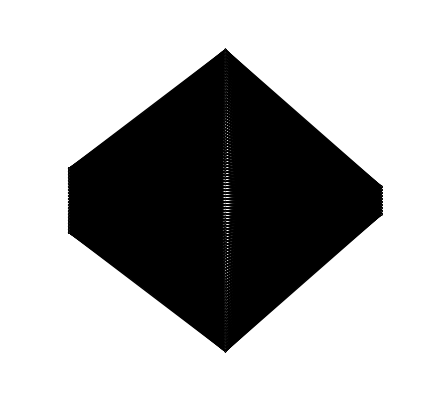

Confusion Matrix:

[[ 50   0   0   1   0   0   0   0   1   0]
 [  0  90   0   0   0   0   0   2   0   0]
 [  0   0 140   0   0   2   0   0   0   0]
 [  0   0   5  49   0   0   0   0   8   0]
 [  0   0   0   0 215   0   0   0   0   0]
 [  0   0   0   3   0  93   0   0   0   0]
 [  0   0   0   0   0   0  32   0   0   0]
 [  0   2   0   0   2   0   0  22   0   1]
 [  0   0   0   0   2   0   0   0 710   1]
 [  0   0   0   0   0   0   0   0   0   8]]


Species,Accuracy,Precision,Recall,F1-score
0,99.86%,100.00%,96.15%,98.04%
1,99.72%,97.83%,97.83%,97.83%
2,99.51%,96.55%,98.59%,97.56%
3,98.82%,92.45%,79.03%,85.22%
4,99.72%,98.17%,100.00%,99.08%
5,99.65%,97.89%,96.88%,97.38%
6,100.00%,100.00%,100.00%,100.00%
7,99.51%,91.67%,81.48%,86.27%
8,99.17%,98.75%,99.58%,99.16%
9,99.86%,80.00%,100.00%,88.89%


Iteration 3

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,1500


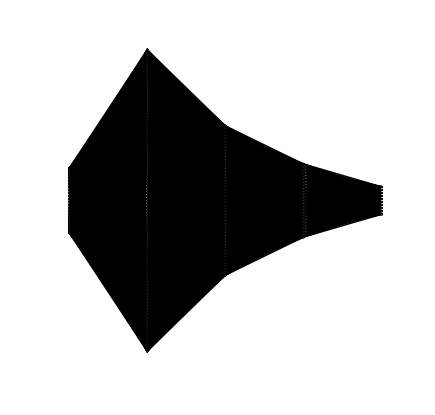

Confusion Matrix:

[[ 53   1   0   0   1   0   0   0   0   1]
 [  0  93   0   0   1   0   0   1   0   0]
 [  0   1 130   2   0   0   0   0   0   0]
 [  0   0   2  43   0   0   2   0   4   0]
 [  0   0   0   0 236   2   0   0   1   0]
 [  0   0   0   1   0   1 126   0   0   0]
 [  0   0   0   0   0  25   0   0   0   0]
 [  0   3   0   0   0   0   0  20   0   0]
 [  0   0   0   0   0   0   0   0 672   0]
 [  1   0   0   0   0   1   0   0   0  15]]


Species,Accuracy,Precision,Recall,F1-score
0,99.72%,98.15%,94.64%,96.36%
1,99.51%,94.90%,97.89%,96.37%
2,99.65%,98.48%,97.74%,98.11%
3,99.24%,93.48%,84.31%,88.66%
4,99.65%,99.16%,98.74%,98.95%
5,89.23%,3.45%,0.78%,1.27%
6,89.37%,0.00%,0.00%,nan%
7,99.72%,95.24%,86.96%,90.91%
8,99.65%,99.26%,100.00%,99.63%
9,99.79%,93.75%,88.24%,90.91%


Iteration 4

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,1500


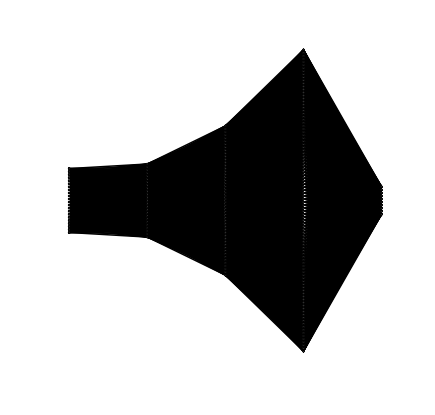

Confusion Matrix:

[[ 49   0   0   0   3   0   0   0   0   0]
 [  0  87   0   0   1   0   0   1   0   0]
 [  0   0 129   3   0   0   0   1   0   0]
 [  0   0   3  66   0   0   0   0   3   0]
 [  2   0   0   0 220   0   0   0   0   0]
 [  0   0   1   1   0  96   0   0   0   0]
 [  0   0   0   1   1   0  25   0   0   3]
 [  0   3   0   0   0   0   0  17   0   0]
 [  0   0   0   1   0   0   0   0 707   0]
 [  0   0   0   0   0   0   0   0   1  14]]


Species,Accuracy,Precision,Recall,F1-score
0,99.65%,96.08%,94.23%,95.15%
1,99.65%,96.67%,97.75%,97.21%
2,99.44%,96.99%,96.99%,96.99%
3,99.17%,91.67%,91.67%,91.67%
4,99.51%,97.78%,99.10%,98.43%
5,99.86%,100.00%,97.96%,98.97%
6,99.65%,100.00%,83.33%,90.91%
7,99.65%,89.47%,85.00%,87.18%
8,99.65%,99.44%,99.86%,99.65%
9,99.72%,82.35%,93.33%,87.50%


<Figure size 432x288 with 0 Axes>

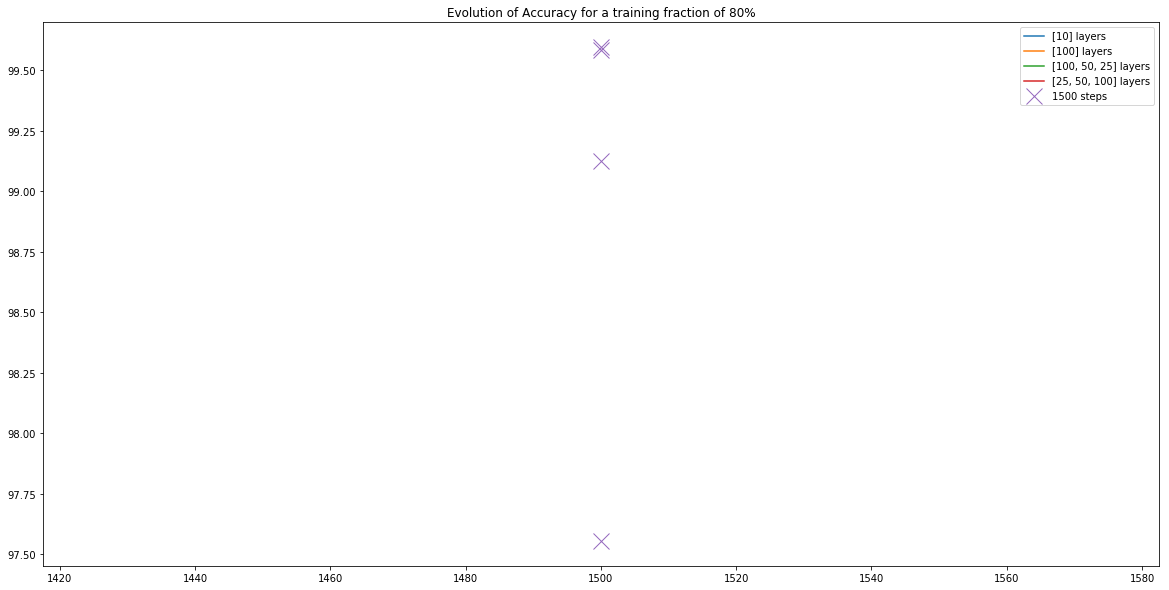

In [30]:
# simple data splitting results
display_model_results(evaluations)

### Cross-Validation approach to dataset splitting
In **k-fold** cross-validation, the original sample is randomly partitioned into k equal size subsamples.

In **stratified k-fold** cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds.

To use one or the other, update the global setting `CROSS_VALIDATION_FUNCTION` in the [Initialize constants](#Initialize-constants) section

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [ ]:
# k-fold cross validation
# this may take a while

# adjustment for k-fold: num_total_model_steps = num_steps * num_folds
kfcv_evaluations = run_model_iterations(df, labels, kFoldCV_tf_data_generator)    


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Ross\\AppData\\Local\\Temp\\tmpkilhqwhm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021D05FAD438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Ross\AppData\Local\Temp\tmpkilhqwhm\m

INFO:tensorflow:global_step/sec: 173.882
INFO:tensorflow:loss = 9.399693, step = 100 (0.576 sec)
INFO:tensorflow:global_step/sec: 191.442
INFO:tensorflow:loss = 12.014847, step = 200 (0.523 sec)
INFO:tensorflow:global_step/sec: 208.605
INFO:tensorflow:loss = 13.360437, step = 300 (0.478 sec)
INFO:tensorflow:global_step/sec: 219.54
INFO:tensorflow:loss = 14.918555, step = 400 (0.456 sec)
INFO:tensorflow:global_step/sec: 207.907
INFO:tensorflow:loss = 5.514541, step = 500 (0.480 sec)
INFO:tensorflow:global_step/sec: 197.018
INFO:tensorflow:loss = 8.145506, step = 600 (0.509 sec)
INFO:tensorflow:global_step/sec: 196.733
INFO:tensorflow:loss = 1.7696173, step = 700 (0.508 sec)
INFO:tensorflow:global_step/sec: 203.09
INFO:tensorflow:loss = 1.6715232, step = 800 (0.493 sec)
INFO:tensorflow:global_step/sec: 200.601
INFO:tensorflow:loss = 0.8088273, step = 900 (0.498 sec)
INFO:tensorflow:global_step/sec: 167.905
INFO:tensorflow:loss = 5.4689593, step = 1000 (0.596 sec)
INFO:tensorflow:global_s

In [ ]:
# k-fold Cross-validation data splitting results
display_model_results(kfcv_evaluations)

# Conclusion
The architectural choices of a **Neural Network** are of tremendous importance when designing such a network and its model, including the architecture, the way the data is split and fed into it, the number of times said data goes through the forward and backpropagation mechanisms. 

With our approach we have observed that, for instance, a **Neural Network** with a single layer comprised of 100 nodes, for our dataset, can better describe (without overfitting) the data then a network with two hidden layers of 10 neurons each.

## Other

### Deletes temporary files created by TensorFlow

In [ ]:
# Allows deleting models save folder in windows
tf.summary.FileWriterCache.clear()

In [ ]:
import tempfile
import os
from pathlib import Path
import shutil

temp_dir = Path(tempfile.gettempdir())
dir_list = [f for f in temp_dir.glob('tmp*') if f.is_dir()] 
for dir in dir_list:
    shutil.rmtree(dir, ignore_errors=True)
        